# Amazon Fine Food Reviews 


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews

The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review

## Importing libraries and loading the dataset :
* Cleaning and handling deduplication of data is already performed.

In [19]:
%matplotlib inline

import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import auc
from sklearn.model_selection import cross_val_score
from collections import Counter
from sklearn.metrics import accuracy_score
from sklearn import datasets, neighbors
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.svm import SVC
from scipy import *
from scipy.sparse import *
from gensim.models import Word2Vec
import warnings
from tqdm import tqdm
warnings.filterwarnings("ignore")

In [2]:
conn = sqlite3.connect('final.sqlite')

In [3]:
data = pd.read_sql_query("""
SELECT *
FROM Reviews""", conn)
data.head(2)

,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
0,138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,positive,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,b'witti littl book make son laugh loud recit c...
1,138688,150506,0006641040,A2IW4PEEKO2R0U,Tracy,1,1,positive,1194739200,"Love the book, miss the hard cover version","I grew up reading these Sendak books, and watc...",b'grew read sendak book watch realli rosi movi...


In [4]:
data.shape

(364171, 12)

## Sorting the DataFrame using Time Column:

In [4]:
data = data.sort_values(by='Time')
data.head(2)

,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
0,138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,positive,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,b'witti littl book make son laugh loud recit c...
30,138683,150501,0006641040,AJ46FKXOVC7NR,Nicholas A Mesiano,2,2,positive,940809600,This whole series is great way to spend time w...,I can remember seeing the show when it aired o...,b'rememb see show air televis year ago child s...


## Preparing the data :

> Seperating training data and values to predict.

In [5]:
# Getting the column names
cols = data.columns
cols = cols[cols != 'Score']
# Train data excluding the score column
X = data[cols]
# Score coumn
Y = data['Score']
# Maping positive as 1 and negative as 0
mapping_dict = {'positive': 1, 'negative': 0}
labels = ['negative', 'positive']
# Mapping is done as some metrics dont work with string so a value of 1 or 0 is given to positive or negative.
Y = Y.map(mapping_dict)

In [6]:
# Getting data :
X_train = X[:80000]
X_cv = X_train[60000:80000]
X_train = X_train[:60000]
X_test =  X[80000:100000]


y_train = Y[:80000]
y_cv = y_train[60000:80000]
y_train = y_train[:60000]
y_test =  Y[80000:100000]

print(X_train.shape, "   ", y_train.shape)
print(X_cv.shape, "   ", y_cv.shape)
print(X_test.shape, "   ", y_test.shape)

(60000, 11)     (60000,)
(20000, 11)     (20000,)
(20000, 11)     (20000,)


## SGDClassifier with Hingle Loss or SVC with Linear Kernel :

In [17]:
def feat_imp(vect, coefs):
    df = pd.DataFrame(data = coefs.reshape(-1,1), index=vect.get_feature_names())
    df_neg = df.sort_values(by = 0).head(10)
    df_pos = df.sort_values(by = 0, ascending=False).head(10)
    print("Negative Features : ")
    print(df_neg)
    print("*********")
    print("Positive Features : ")
    print(df_pos)

In [8]:
# Plots confusion matrix using heatmap and calculates and displays TN,FN,TP,FP
def plot_confusion_matrix(y_actual, y_predicted):
    cm = confusion_matrix(y_predicted, y_actual)
    df = pd.DataFrame(data=cm, index=labels, columns=labels)
    print("Confusion Matrix : ")
    plt.figure(figsize=(10,7))
    sns.heatmap(df, annot=True)
    plt.show()
    
    TP = 0
    FP = 0
    TN = 0
    FN = 0

    for i in range(len(y_predicted)): 
        if y_actual[i]== 1 and y_predicted[i]==1:
            TP += 1
        if y_predicted[i]==1 and y_actual[i]!=y_predicted[i]:
            FP += 1
        if y_actual[i]==y_predicted[i]==0:
            TN += 1
        if y_predicted[i]==0 and y_actual[i]!=y_predicted[i]:
            FN += 1
            
    print("True Positives :", TP)
    print("False Positives :", FP)
    print("True Negatives :", TN)
    print("False Negatives :", FN)

### For Bow Data :

In [9]:
cnt_vec = CountVectorizer(ngram_range=(1,2))
bow_train = cnt_vec.fit_transform(X_train['CleanedText'])
bow_cv  = cnt_vec.transform(X_cv['CleanedText'])
bow_test = cnt_vec.transform(X_test['CleanedText'])

##### HyperParameter Tuning :

In [24]:
# Hyperparameter tuning :
penalties = ['l1', 'l2']
C = [0.00001, 0.00005, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100]
cv_scores = []
tr_scores = []
i = 0
for alpha in C:
    for p in penalties:
        m = SGDClassifier(loss='hinge', penalty=p, alpha=alpha)
        clf = CalibratedClassifierCV(base_estimator=m, cv=None)
        clf.fit(bow_train, y_train)
        scores = roc_auc_score(y_true=np.array(y_cv), y_score=clf.predict_proba(bow_cv)[:,1])
        cv_scores.append(scores)
        scores = roc_auc_score(y_true=np.array(y_train), y_score=clf.predict_proba(bow_train)[:,1])
        tr_scores.append(scores)
        print("CV ROC_AUC Score : ", cv_scores[i], " Train ROC_AUC Score : ", tr_scores[i], "C : ", alpha, " penalty : ", p)
        i += 1

CV ROC_AUC Score :  0.9269256159552063  Train ROC_AUC Score :  0.9907756114688423 C :  1e-05  penalty :  l1
CV ROC_AUC Score :  0.91928895551928  Train ROC_AUC Score :  0.9990405387878327 C :  1e-05  penalty :  l2
CV ROC_AUC Score :  0.9205223037951129  Train ROC_AUC Score :  0.9610021573685849 C :  5e-05  penalty :  l1
CV ROC_AUC Score :  0.9314294897277364  Train ROC_AUC Score :  0.998729028919514 C :  5e-05  penalty :  l2
CV ROC_AUC Score :  0.9168015791120772  Train ROC_AUC Score :  0.94607696692047 C :  0.0001  penalty :  l1
CV ROC_AUC Score :  0.932518343327892  Train ROC_AUC Score :  0.9988100164882475 C :  0.0001  penalty :  l2
CV ROC_AUC Score :  0.8778073009616767  Train ROC_AUC Score :  0.8819249721795195 C :  0.001  penalty :  l1
CV ROC_AUC Score :  0.9389738943255153  Train ROC_AUC Score :  0.9885069216997431 C :  0.001  penalty :  l2
CV ROC_AUC Score :  0.6705988065735721  Train ROC_AUC Score :  0.6727176345009691 C :  0.01  penalty :  l1
CV ROC_AUC Score :  0.91218221109

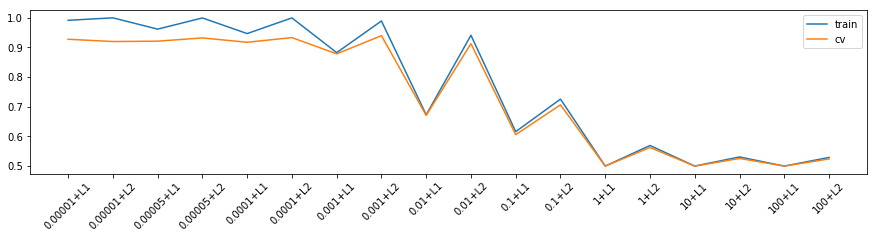

In [25]:
ticks = ['0.00001+L1', '0.00001+L2', '0.00005+L1', '0.00005+L2', '0.0001+L1', '0.0001+L2', '0.001+L1', '0.001+L2',
         '0.01+L1', '0.01+L2', '0.1+L1', '0.1+L2', '1+L1', '1+L2', '10+L1', '10+L2', '100+L1', '100+L2']
plt.figure(figsize=(15,3))
plt.plot(range(len(C)*len(penalties)), tr_scores)
plt.plot(range(len(C)*len(penalties)), cv_scores)
plt.xticks(range(len(C)*len(penalties)), ticks, rotation = 45)
plt.legend(['train', 'cv'])
plt.show()

In [34]:
m = SGDClassifier(loss = 'hinge', penalty='l1', alpha=5e-05)
m.fit(bow_train, y_train)

SGDClassifier(alpha=5e-05, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=None,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l1',
       power_t=0.5, random_state=None, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False)

In [26]:
m = SGDClassifier(loss='hinge', penalty='l1', alpha=5e-05)
model = CalibratedClassifierCV(base_estimator=m, cv=None)
model.fit(bow_train, y_train)

CalibratedClassifierCV(base_estimator=SGDClassifier(alpha=5e-05, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=None,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l1',
       power_t=0.5, random_state=None, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False),
            cv=None, method='sigmoid')

##### Test Metrics :

In [27]:
y_pred = model.predict(bow_test)

Confusion Matrix : 


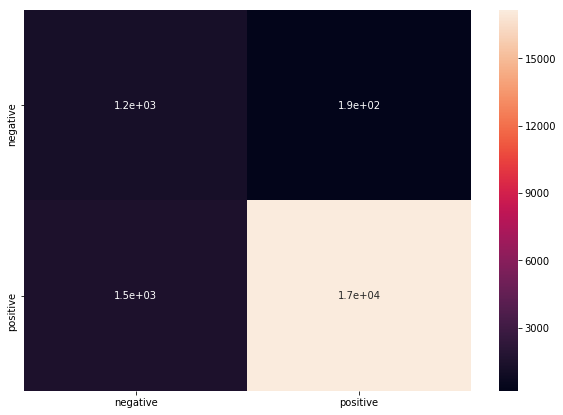

True Positives : 17130
False Positives : 1484
True Negatives : 1194
False Negatives : 192


In [28]:
plot_confusion_matrix(np.array(y_test), y_pred)

In [30]:
y_pred = model.predict_proba(bow_test)
roc_auc_score(y_true=y_test, y_score=y_pred[:,1])

0.9305193467251538

##### Feature Importance :

In [35]:
feat_imp(cnt_vec, m.coef_)

Negative Features : 
                  0
worst    -58.841819
nippl    -55.591191
bug      -42.069420
aw       -36.520708
threw    -35.335893
two star -32.983963
terribl  -32.952091
horribl  -32.665655
wont buy -32.632417
krup     -31.380053
*********
Positive Features : 
                         0
red espresso    101.305195
espresso maker   42.536937
amaz             36.809453
refresh          36.259337
stovetop         33.306727
fussi            31.822686
fish oil         30.620215
neosur           30.494144
rooibo           30.426609
addict           30.121550


#### Conclusions for Bow Data :
1. CV ROC_AUC Score :  0.9205223037951129
2. Train ROC_AUC Score :  0.9610021573685849
3. Test ROC_AUC Score : 0.9305193467251538
4. alpha :  5e-05
5. penalty :  l1

### TFIDF Data :

In [39]:
tfidf_vec = TfidfVectorizer(ngram_range=(1,2))
tf_train = tfidf_vec.fit_transform(X_train['CleanedText'])
tf_cv  = tfidf_vec.transform(X_cv['CleanedText'])
tf_test = tfidf_vec.transform(X_test['CleanedText'])

##### HyperParameter Tuning :

In [40]:
# Hyperparameter tuning :
penalties = ['l1', 'l2']
C = [0.00001, 0.00005, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100]
cv_scores = []
tr_scores = []
i = 0
for alpha in C:
    for p in penalties:
        m = SGDClassifier(loss='hinge', penalty=p, alpha=alpha)
        clf = CalibratedClassifierCV(base_estimator=m, cv=None)
        clf.fit(tf_train, y_train)
        scores = roc_auc_score(y_true=np.array(y_cv), y_score=clf.predict_proba(tf_cv)[:,1])
        cv_scores.append(scores)
        scores = roc_auc_score(y_true=np.array(y_train), y_score=clf.predict_proba(tf_train)[:,1])
        tr_scores.append(scores)
        print("CV ROC_AUC Score : ", cv_scores[i], " Train ROC_AUC Score : ", tr_scores[i], "C : ", alpha, " penalty : ", p)
        i += 1

CV ROC_AUC Score :  0.9484688871784897  Train ROC_AUC Score :  0.9719169517002875 C :  1e-05  penalty :  l1
CV ROC_AUC Score :  0.9524994079386964  Train ROC_AUC Score :  0.9997392690105483 C :  1e-05  penalty :  l2
CV ROC_AUC Score :  0.9267868410146239  Train ROC_AUC Score :  0.9285371028235794 C :  5e-05  penalty :  l1
CV ROC_AUC Score :  0.9472915521309977  Train ROC_AUC Score :  0.9915408680769671 C :  5e-05  penalty :  l2
CV ROC_AUC Score :  0.9008791370283596  Train ROC_AUC Score :  0.9002744099454876 C :  0.0001  penalty :  l1
CV ROC_AUC Score :  0.9446142086254873  Train ROC_AUC Score :  0.9876927600987623 C :  0.0001  penalty :  l2
CV ROC_AUC Score :  0.5954032360379258  Train ROC_AUC Score :  0.5955868938364172 C :  0.001  penalty :  l1
CV ROC_AUC Score :  0.9442396664157455  Train ROC_AUC Score :  0.9872570438489682 C :  0.001  penalty :  l2
CV ROC_AUC Score :  0.5  Train ROC_AUC Score :  0.5 C :  0.01  penalty :  l1
CV ROC_AUC Score :  0.9442183099187184  Train ROC_AUC Sco

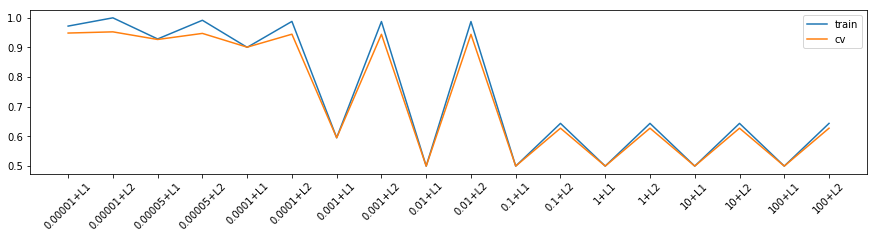

In [41]:
ticks = ['0.00001+L1', '0.00001+L2', '0.00005+L1', '0.00005+L2', '0.0001+L1', '0.0001+L2', '0.001+L1', '0.001+L2',
         '0.01+L1', '0.01+L2', '0.1+L1', '0.1+L2', '1+L1', '1+L2', '10+L1', '10+L2', '100+L1', '100+L2']
plt.figure(figsize=(15,3))
plt.plot(range(len(C)*len(penalties)), tr_scores)
plt.plot(range(len(C)*len(penalties)), cv_scores)
plt.xticks(range(len(C)*len(penalties)), ticks, rotation = 45)
plt.legend(['train', 'cv'])
plt.show()

In [48]:
m = SGDClassifier(loss = 'hinge', penalty='l1', alpha=1e-05)
m.fit(tf_train, y_train)

SGDClassifier(alpha=1e-05, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=None,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l1',
       power_t=0.5, random_state=None, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False)

In [43]:
m = SGDClassifier(loss='hinge', penalty='l1', alpha=1e-05)
model = CalibratedClassifierCV(base_estimator=m, cv=None)
model.fit(tf_train, y_train)

CalibratedClassifierCV(base_estimator=SGDClassifier(alpha=1e-05, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=None,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l1',
       power_t=0.5, random_state=None, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False),
            cv=None, method='sigmoid')

##### Test Metrics :

Confusion Matrix : 


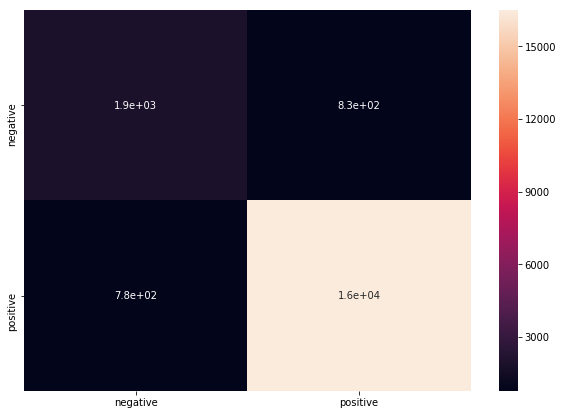

True Positives : 16494
False Positives : 776
True Negatives : 1902
False Negatives : 828


In [44]:
y_pred = model.predict(bow_test)
plot_confusion_matrix(np.array(y_test), y_pred)

In [46]:
y_pred = model.predict_proba(tf_test)
roc_auc_score(y_true=y_test, y_score=y_pred[:,1])

0.9508753346424559

##### Feature Importance :

In [49]:
feat_imp(tfidf_vec, m.coef_)

Negative Features : 
                    0
worst      -16.034563
disappoint -12.475374
two star   -12.136164
terribl    -10.711550
aw          -9.758374
wont buy    -9.599623
threw       -9.562738
horribl     -9.439472
unpleas     -9.086670
wors        -8.911053
*********
Positive Features : 
                         0
delici           12.539226
perfect          11.634454
great            11.473608
best             11.152539
excel            10.470136
amaz             10.079936
wont disappoint   9.603024
high recommend    8.965628
love              8.653173
smooth            7.446703


#### Conclusions for TFIDF Data :

1. CV ROC_AUC Score :  0.9484688871784897
2. Train ROC_AUC Score :  0.9719169517002875
3. Test ROC_AUC Score : 0.9508753346424559
4. C :  1e-05
5. penalty :  l1

### Word2Vec :

In [51]:
# Train your own Word2Vec model using your own text corpus
i=0
list_of_sent_train=[]
for sentance in X_train['CleanedText']:
    list_of_sent_train.append(sentance.split())
    
i=0
list_of_sent_test=[]
for sentance in X_test['CleanedText']:
    list_of_sent_test.append(sentance.split())
    
i=0
list_of_sent_cv=[]
for sentance in X_cv['CleanedText']:
    list_of_sent_cv.append(sentance.split())
    
print(len(list_of_sent_train))
print(len(list_of_sent_cv))
print(len(list_of_sent_test))

60000
20000
20000


In [52]:
def convertByteStringtoString(sentlist):
    for x in sentlist:
        for i in range(len(x)):
            x[i] = x[i].decode("utf-8")
            
    return sentlist

list_of_sent_train = convertByteStringtoString(list_of_sent_train)
list_of_sent_cv = convertByteStringtoString(list_of_sent_cv)
list_of_sent_test = convertByteStringtoString(list_of_sent_test)

In [75]:
np.save("list_of_sent_train", np.array(list_of_sent_train))
np.save("list_of_sent_test", np.array(list_of_sent_test))
np.save("list_of_sent_cv", np.array(list_of_sent_cv))

In [53]:
# Training word 2 vec on our train set --
w2v_model=Word2Vec(list_of_sent_train,min_count=5,size=50, workers=4)

In [54]:
w2v_words = list(w2v_model.wv.vocab)

### Average Word2Vec :

In [57]:
def avgw2vvectors(list_of_sent):
    sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
    for sent in tqdm(list_of_sent): # for each review/sentence
        sent_vec = np.zeros(50) # as word vectors are of zero length 200, you might need to change this to 300 if you use google's w2v
        cnt_words = 0; # num of words with a valid vector in the sentence/review
        for word in sent: # for each word in a review/sentence
            if word in w2v_words:
                vec = w2v_model.wv[word]
                sent_vec += vec
                cnt_words += 1
        if cnt_words != 0:
            sent_vec /= cnt_words
        sent_vectors.append(sent_vec)
    print(len(sent_vectors))
    print(len(sent_vectors[0]))
    return np.array(sent_vectors)

In [58]:
train_avgw2v = avgw2vvectors(list_of_sent_train)

100%|███████████████████████████████████████████████████████████████████████████| 60000/60000 [01:53<00:00, 529.84it/s]


60000
50


In [59]:
cv_avgw2v = avgw2vvectors(list_of_sent_cv)

100%|███████████████████████████████████████████████████████████████████████████| 20000/20000 [00:45<00:00, 442.79it/s]


20000
50


In [60]:
test_avgw2v = avgw2vvectors(list_of_sent_test)

100%|███████████████████████████████████████████████████████████████████████████| 20000/20000 [00:38<00:00, 525.72it/s]


20000
50


In [61]:
np.save("train_avgw2v", train_avgw2v)
np.save("cv_avgw2v", cv_avgw2v)
np.save("test_avgw2v", test_avgw2v)

In [62]:
np.save("y_train", np.array(y_train))
np.save("y_cv", np.array(y_cv))
np.save("y_test", np.array(y_test))

##### HyperParameter Tuning :

In [63]:
# Hyperparameter tuning :
penalties = ['l1', 'l2']
C = [0.00001, 0.00005, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100]
cv_scores = []
tr_scores = []
i = 0
for alpha in C:
    for p in penalties:
        m = SGDClassifier(loss='hinge', penalty=p, alpha=alpha)
        clf = CalibratedClassifierCV(base_estimator=m, cv=None)
        clf.fit(train_avgw2v, y_train)
        scores = roc_auc_score(y_true=np.array(y_cv), y_score=clf.predict_proba(cv_avgw2v)[:,1])
        cv_scores.append(scores)
        scores = roc_auc_score(y_true=np.array(y_train), y_score=clf.predict_proba(train_avgw2v)[:,1])
        tr_scores.append(scores)
        print("CV ROC_AUC Score : ", cv_scores[i], " Train ROC_AUC Score : ", tr_scores[i], "C : ", alpha, " penalty : ", p)
        i += 1

CV ROC_AUC Score :  0.889573779296462  Train ROC_AUC Score :  0.884071778362111 C :  1e-05  penalty :  l1
CV ROC_AUC Score :  0.8862300285035227  Train ROC_AUC Score :  0.8791583284344828 C :  1e-05  penalty :  l2
CV ROC_AUC Score :  0.8924608393737683  Train ROC_AUC Score :  0.8841580128116749 C :  5e-05  penalty :  l1
CV ROC_AUC Score :  0.8925063223689218  Train ROC_AUC Score :  0.8848946435801678 C :  5e-05  penalty :  l2
CV ROC_AUC Score :  0.8942912180392621  Train ROC_AUC Score :  0.8866553276565743 C :  0.0001  penalty :  l1
CV ROC_AUC Score :  0.8942463271054123  Train ROC_AUC Score :  0.888922990563596 C :  0.0001  penalty :  l2
CV ROC_AUC Score :  0.8962665882890274  Train ROC_AUC Score :  0.8898917800215093 C :  0.001  penalty :  l1
CV ROC_AUC Score :  0.896676337001294  Train ROC_AUC Score :  0.8902927614259952 C :  0.001  penalty :  l2
CV ROC_AUC Score :  0.840449649415128  Train ROC_AUC Score :  0.8383201746128992 C :  0.01  penalty :  l1
CV ROC_AUC Score :  0.8960528118

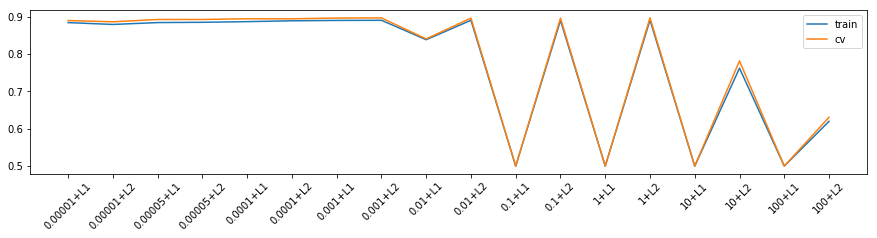

In [64]:
ticks = ['0.00001+L1', '0.00001+L2', '0.00005+L1', '0.00005+L2', '0.0001+L1', '0.0001+L2', '0.001+L1', '0.001+L2',
         '0.01+L1', '0.01+L2', '0.1+L1', '0.1+L2', '1+L1', '1+L2', '10+L1', '10+L2', '100+L1', '100+L2']
plt.figure(figsize=(15,3))
plt.plot(range(len(C)*len(penalties)), tr_scores)
plt.plot(range(len(C)*len(penalties)), cv_scores)
plt.xticks(range(len(C)*len(penalties)), ticks, rotation = 45)
plt.legend(['train', 'cv'])
plt.show()

In [71]:
m = SGDClassifier(loss='hinge', penalty='l2', alpha=0.001)
model = CalibratedClassifierCV(base_estimator=m, cv=None)
model.fit(train_avgw2v, y_train)

CalibratedClassifierCV(base_estimator=SGDClassifier(alpha=0.001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=None,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l2',
       power_t=0.5, random_state=None, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False),
            cv=None, method='sigmoid')

##### Test Metrics :

Confusion Matrix : 


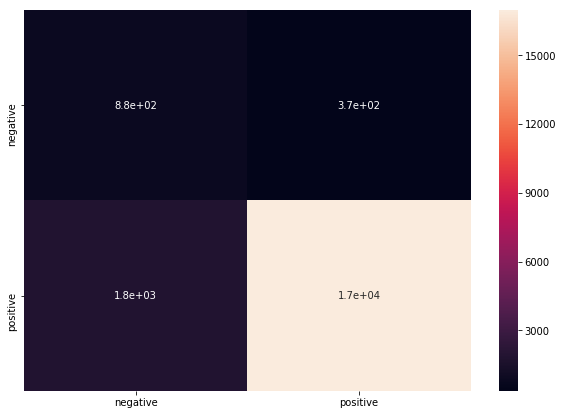

True Positives : 16956
False Positives : 1802
True Negatives : 876
False Negatives : 366


In [73]:
y_pred = model.predict(test_avgw2v)
plot_confusion_matrix(np.array(y_test), y_pred)

In [74]:
y_pred = model.predict_proba(test_avgw2v)
roc_auc_score(y_true=y_test, y_score=y_pred[:,1])

0.8955613844658642

#### Conclusions For Average W2V :

1. CV ROC_AUC Score :  0.896676337001294
2. Train ROC_AUC Score :  0.8902927614259952
3. Test ROC_AUC Score : 0.8955613844658642
4. alpha = 0.001
5. penalty :  l2

### TFIDF W2V :

In [76]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
model = TfidfVectorizer()
tf_idf_matrix = model.fit_transform(X_train['CleanedText'])
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [77]:
def tfidfw2v(list_of_sent):
    # TF-IDF weighted Word2Vec
    tfidf_feat = model.get_feature_names() # tfidf words/col-names
    # final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

    tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
    row=0;
    for sent in tqdm(list_of_sent): # for each review/sentence 
        sent_vec = np.zeros(50) # as word vectors are of zero length
        weight_sum =0; # num of words with a valid vector in the sentence/review
        for word in sent: # for each word in a review/sentence
            if word in w2v_words and word in tfidf_feat:
                vec = w2v_model.wv[word]
                #tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
                # to reduce the computation we are 
                # dictionary[word] = idf value of word in whole courpus
                # sent.count(word) = tf valeus of word in this review
                tf_idf = dictionary[word]*(sent.count(word)/len(sent))
                sent_vec += (vec * tf_idf)
                weight_sum += tf_idf
        if weight_sum != 0:
            sent_vec /= weight_sum
        tfidf_sent_vectors.append(sent_vec)
    row += 1
    
    return np.array(tfidf_sent_vectors)

In [78]:
train_tfidf = tfidfw2v(list_of_sent_train)
train_tfidf.shape

100%|████████████████████████████████████████████████████████████████████████████| 60000/60000 [19:48<00:00, 50.47it/s]


(60000, 50)

In [79]:
cv_tfidf = tfidfw2v(list_of_sent_cv)
cv_tfidf.shape

100%|████████████████████████████████████████████████████████████████████████████| 20000/20000 [06:42<00:00, 49.67it/s]


(20000, 50)

In [80]:
test_tfidf = tfidfw2v(list_of_sent_test)
test_tfidf.shape

100%|████████████████████████████████████████████████████████████████████████████| 20000/20000 [06:35<00:00, 50.58it/s]


(20000, 50)

In [81]:
np.save("train_tfidf", train_tfidf)
np.save("cv_tfidf", cv_tfidf)
np.save("test_tfidf", test_tfidf)

##### HyperParameter Tuning :

In [82]:
# Hyperparameter tuning :
penalties = ['l1', 'l2']
C = [0.00001, 0.00005, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100]
cv_scores = []
tr_scores = []
i = 0
for alpha in C:
    for p in penalties:
        m = SGDClassifier(loss='hinge', penalty=p, alpha=alpha)
        clf = CalibratedClassifierCV(base_estimator=m, cv=None)
        clf.fit(train_tfidf, y_train)
        scores = roc_auc_score(y_true=np.array(y_cv), y_score=clf.predict_proba(cv_tfidf)[:,1])
        cv_scores.append(scores)
        scores = roc_auc_score(y_true=np.array(y_train), y_score=clf.predict_proba(train_tfidf)[:,1])
        tr_scores.append(scores)
        print("CV ROC_AUC Score : ", cv_scores[i], " Train ROC_AUC Score : ", tr_scores[i], "alpha : ", alpha, " penalty : ", p)
        i += 1

CV ROC_AUC Score :  0.8482378563997598  Train ROC_AUC Score :  0.842157470337462 alpha :  1e-05  penalty :  l1
CV ROC_AUC Score :  0.8411602498498701  Train ROC_AUC Score :  0.8320123585541761 alpha :  1e-05  penalty :  l2
CV ROC_AUC Score :  0.8544391910750987  Train ROC_AUC Score :  0.8502321975399508 alpha :  5e-05  penalty :  l1
CV ROC_AUC Score :  0.8452680980453519  Train ROC_AUC Score :  0.8410577834208456 alpha :  5e-05  penalty :  l2
CV ROC_AUC Score :  0.8639065684972638  Train ROC_AUC Score :  0.8597068919394131 alpha :  0.0001  penalty :  l1
CV ROC_AUC Score :  0.8553171756984208  Train ROC_AUC Score :  0.8534581890906716 alpha :  0.0001  penalty :  l2
CV ROC_AUC Score :  0.8603579856382844  Train ROC_AUC Score :  0.8532486954987152 alpha :  0.001  penalty :  l1
CV ROC_AUC Score :  0.8672264676776819  Train ROC_AUC Score :  0.8617988131676368 alpha :  0.001  penalty :  l2
CV ROC_AUC Score :  0.7620041275130888  Train ROC_AUC Score :  0.7643907863004442 alpha :  0.01  penalt

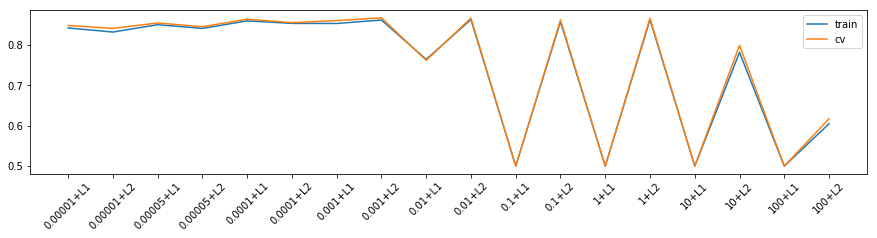

In [83]:
ticks = ['0.00001+L1', '0.00001+L2', '0.00005+L1', '0.00005+L2', '0.0001+L1', '0.0001+L2', '0.001+L1', '0.001+L2',
         '0.01+L1', '0.01+L2', '0.1+L1', '0.1+L2', '1+L1', '1+L2', '10+L1', '10+L2', '100+L1', '100+L2']
plt.figure(figsize=(15,3))
plt.plot(range(len(C)*len(penalties)), tr_scores)
plt.plot(range(len(C)*len(penalties)), cv_scores)
plt.xticks(range(len(C)*len(penalties)), ticks, rotation = 45)
plt.legend(['train', 'cv'])
plt.show()

In [84]:
m = SGDClassifier(loss='hinge', penalty='l1', alpha=0.0001)
model = CalibratedClassifierCV(base_estimator=m, cv=None)
model.fit(train_tfidf, y_train)

CalibratedClassifierCV(base_estimator=SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=None,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l1',
       power_t=0.5, random_state=None, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False),
            cv=None, method='sigmoid')

##### Test Metrics :

Confusion Matrix : 


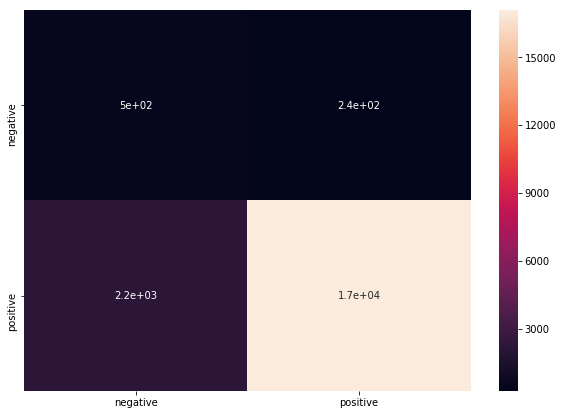

True Positives : 17078
False Positives : 2182
True Negatives : 496
False Negatives : 244


In [85]:
y_pred = model.predict(test_tfidf)
plot_confusion_matrix(np.array(y_test), y_pred)

In [86]:
y_pred = model.predict_proba(test_tfidf)
roc_auc_score(y_true=y_test, y_score=y_pred[:,1])

0.8587122347791198

#### Conclusions for TFIDF W2V :

1. CV ROC_AUC Score :  0.8639065684972638
2. Train ROC_AUC Score :  0.8597068919394131
3. Test ROC_AUC_Score :  0.8587122347791198
4. alpha :  0.0001
5. penalty :  l1

## SVC with RBF Kernel :

In [ ]:
# Getting data :
X_train = X[:80000]
X_cv = X_train[60000:80000]
X_train = X_train[:60000]
X_test =  X[80000:100000]


y_train = Y[:80000]
y_cv = y_train[60000:80000]
y_train = y_train[:60000]
y_test =  Y[80000:100000]

print(X_train.shape, "   ", y_train.shape)
print(X_cv.shape, "   ", y_cv.shape)
print(X_test.shape, "   ", y_test.shape)

In [87]:
X_cv = X_train[13000:16000]
X_test = X_train[16000:20000]
X_train = X_train[:13000]

y_cv = np.array(y_train[13000:16000])
y_test = np.array(y_train[16000:20000])
y_train = np.array(y_train[:13000])

print(X_train.shape, "   ", y_train.shape)
print(X_cv.shape, "   ", y_cv.shape)
print(X_test.shape, "   ", y_test.shape)

(13000, 11)     (13000,)
(3000, 11)     (3000,)
(4000, 11)     (4000,)


### Bow Data :

In [139]:
cnt_vec = CountVectorizer(ngram_range=(1,2), min_df=10, max_features=200)
bow_train = cnt_vec.fit_transform(X_train['CleanedText'])
bow_cv  = cnt_vec.transform(X_cv['CleanedText'])
bow_test = cnt_vec.transform(X_test['CleanedText'])

print(bow_train.shape)
print(bow_cv.shape)
print(bow_test.shape)

(13000, 200)
(3000, 200)
(4000, 200)


##### HyperParameter Tuning :

In [140]:
# Hyperparameter tuning :
degree = [3, 4]
C = [0.00001, 0.00005, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100]
cv_scores = []
tr_scores = []
i = 0
for alpha in C:
    for p in degree:
        clf = SVC(C=alpha, kernel='rbf',  degree=p, probability=True, verbose=10)
        clf.fit(bow_train, y_train)
        scores = roc_auc_score(y_true=np.array(y_cv), y_score=clf.predict_proba(bow_cv)[:,1])
        cv_scores.append(scores)
        scores = roc_auc_score(y_true=np.array(y_train), y_score=clf.predict_proba(bow_train)[:,1])
        tr_scores.append(scores)
        print("CV ROC_AUC Score : ", cv_scores[i], " Train ROC_AUC Score : ", tr_scores[i], "C : ", alpha, " degree : ", p)
        i += 1

[LibSVM]CV ROC_AUC Score :  0.5026451725746268  Train ROC_AUC Score :  0.4958874158638994 C :  1e-05  degree :  3
[LibSVM]CV ROC_AUC Score :  0.5026504197761194  Train ROC_AUC Score :  0.495809541051051 C :  1e-05  degree :  4
[LibSVM]CV ROC_AUC Score :  0.6300478078358209  Train ROC_AUC Score :  0.6090461153875073 C :  5e-05  degree :  3
[LibSVM]CV ROC_AUC Score :  0.6286357276119403  Train ROC_AUC Score :  0.605571005307642 C :  5e-05  degree :  4
[LibSVM]CV ROC_AUC Score :  0.6835867537313434  Train ROC_AUC Score :  0.6655174482030188 C :  0.0001  degree :  3
[LibSVM]CV ROC_AUC Score :  0.6835867537313434  Train ROC_AUC Score :  0.6655174176638765 C :  0.0001  degree :  4
[LibSVM]CV ROC_AUC Score :  0.8153066697761194  Train ROC_AUC Score :  0.8257463109784979 C :  0.001  degree :  3
[LibSVM]CV ROC_AUC Score :  0.8153078358208955  Train ROC_AUC Score :  0.8257466163699209 C :  0.001  degree :  4
[LibSVM]CV ROC_AUC Score :  0.8489132462686567  Train ROC_AUC Score :  0.901684820049020

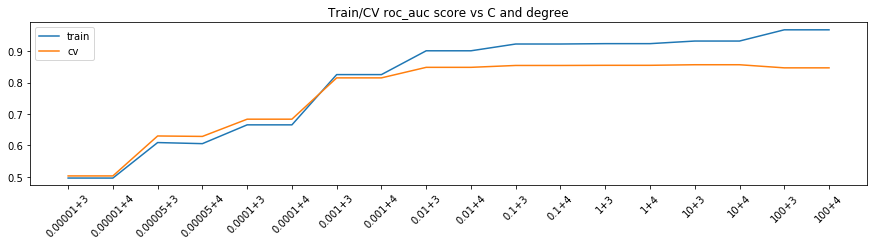

In [141]:
ticks = ['0.00001+3', '0.00001+4', '0.00005+3', '0.00005+4', '0.0001+3', '0.0001+4', '0.001+3', '0.001+4',
         '0.01+3', '0.01+4', '0.1+3', '0.1+4', '1+3', '1+4', '10+3', '10+4', '100+3', '100+4']
plt.figure(figsize=(15,3))
plt.plot(range(len(C)*len(penalties)), tr_scores)
plt.plot(range(len(C)*len(penalties)), cv_scores)
plt.xticks(range(len(C)*len(penalties)), ticks, rotation = 45)
plt.legend(['train', 'cv'])
plt.title("Train/CV roc_auc score vs C and degree")
plt.show()

In [145]:
model = SVC(C=1, degree=3, kernel='rbf', probability=True)
model.fit(bow_train, y_train)

SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=True, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

##### Test Metrics :

In [146]:
y_pred = model.predict_proba(bow_test)
roc_auc_score(y_true=y_test, y_score=y_pred[:,1])

0.8378130497305225

#### Conclusions for Bow Data :
1. CV ROC_AUC Score :  0.8553708022388059
2. Train ROC_AUC Score :  0.9244714789147684
3. Test ROC_AUC Score : 0.8378130497305225
4. C :  1
5. degree :  3

### TFIDF Data :

In [147]:
tfidf_vec = TfidfVectorizer(ngram_range=(1,2), min_df=10, max_features=200)
tf_train = tfidf_vec.fit_transform(X_train['CleanedText'])
tf_cv  = tfidf_vec.transform(X_cv['CleanedText'])
tf_test = tfidf_vec.transform(X_test['CleanedText'])

print(tf_train.shape)
print(tf_cv.shape)
print(tf_test.shape)

(13000, 200)
(3000, 200)
(4000, 200)


In [148]:
# Hyperparameter tuning :
degree = [3, 4]
C = [0.00001, 0.00005, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100]
cv_scores = []
tr_scores = []
i = 0
for alpha in C:
    for p in degree:
        clf = SVC(C=alpha, kernel='rbf',  degree=p, probability=True, verbose=10)
        clf.fit(tf_train, y_train)
        scores = roc_auc_score(y_true=np.array(y_cv), y_score=clf.predict_proba(tf_cv)[:,1])
        cv_scores.append(scores)
        scores = roc_auc_score(y_true=np.array(y_train), y_score=clf.predict_proba(tf_train)[:,1])
        tr_scores.append(scores)
        print("CV ROC_AUC Score : ", cv_scores[i], " Train ROC_AUC Score : ", tr_scores[i], "C : ", alpha, " degree : ", p)
        i += 1

[LibSVM]CV ROC_AUC Score :  0.771279151119403  Train ROC_AUC Score :  0.7738291582966512 C :  1e-05  degree :  3
[LibSVM]CV ROC_AUC Score :  0.777811333955224  Train ROC_AUC Score :  0.7789485263367426 C :  1e-05  degree :  4
[LibSVM]CV ROC_AUC Score :  0.7724580223880596  Train ROC_AUC Score :  0.7736352347430874 C :  5e-05  degree :  3
[LibSVM]CV ROC_AUC Score :  0.7799096315298506  Train ROC_AUC Score :  0.7803553424656363 C :  5e-05  degree :  4
[LibSVM]CV ROC_AUC Score :  0.7769881063432837  Train ROC_AUC Score :  0.778468328863319 C :  0.0001  degree :  3
[LibSVM]CV ROC_AUC Score :  0.7723495802238807  Train ROC_AUC Score :  0.7759528502517434 C :  0.0001  degree :  4
[LibSVM]CV ROC_AUC Score :  0.7714056669776119  Train ROC_AUC Score :  0.7740107134975862 C :  0.001  degree :  3
[LibSVM]CV ROC_AUC Score :  0.7802203824626864  Train ROC_AUC Score :  0.7807260265747952 C :  0.001  degree :  4
[LibSVM]CV ROC_AUC Score :  0.8511077425373135  Train ROC_AUC Score :  0.8512253006288437

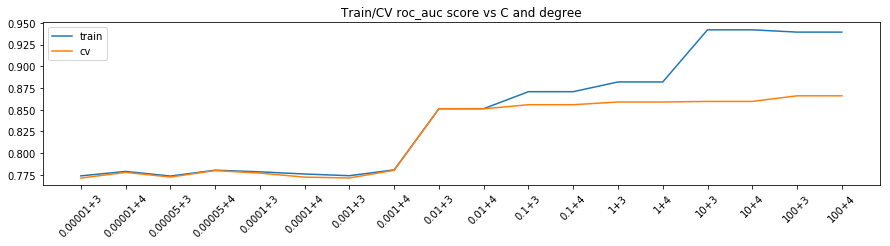

In [149]:
ticks = ['0.00001+3', '0.00001+4', '0.00005+3', '0.00005+4', '0.0001+3', '0.0001+4', '0.001+3', '0.001+4',
         '0.01+3', '0.01+4', '0.1+3', '0.1+4', '1+3', '1+4', '10+3', '10+4', '100+3', '100+4']
plt.figure(figsize=(15,3))
plt.plot(range(len(C)*len(penalties)), tr_scores)
plt.plot(range(len(C)*len(penalties)), cv_scores)
plt.xticks(range(len(C)*len(penalties)), ticks, rotation = 45)
plt.legend(['train', 'cv'])
plt.title("Train/CV roc_auc score vs C and degree")
plt.show()

In [150]:
model = SVC(C=1, degree=3, kernel='rbf', probability=True)
model.fit(tf_train, y_train)

SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=True, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

##### Test Metrics :

In [151]:
y_pred = model.predict_proba(tf_test)
roc_auc_score(y_true=y_test, y_score=y_pred[:,1])

0.8395699574200758

#### Conclusion for TFIDF Data :
1. CV ROC_AUC Score :  0.8589062500000001
2. Train ROC_AUC Score :  0.8820058243030617
3. Test ROC_AUC Score : 0.8395699574200758
4. C :  1
5. degree :  3

### AVGW2V :

In [152]:
y_train = np.load("y_train.npy")

In [153]:
cv_avgw2v = train_avgw2v[20000:30000]
test_avgw2v = train_avgw2v[30000:40000]
train_avgw2v = train_avgw2v[:20000]

y_cv = y_train[20000:30000]
y_test = y_train[30000:40000]
y_train = y_train[:20000]

print("train shape ", train_avgw2v.shape, "y_train shape - ", y_train.shape)
print("Cv shape ", cv_avgw2v.shape, "y_cv shape - ", y_cv.shape)
print("Test shape ", test_avgw2v.shape, "y_test shape - ", y_test.shape)

train shape  (20000, 50) y_train shape -  (20000,)
Cv shape  (10000, 50) y_cv shape -  (10000,)
Test shape  (10000, 50) y_test shape -  (10000,)


##### HyperParameter Tuning :

In [154]:
# Hyperparameter tuning :
degree = [3, 4]
C = [0.00001, 0.00005, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100]
cv_scores = []
tr_scores = []
i = 0
for alpha in C:
    for p in degree:
        clf = SVC(C=alpha, kernel='rbf',  degree=p, probability=True, verbose=10)
        clf.fit(train_avgw2v, y_train)
        scores = roc_auc_score(y_true=np.array(y_cv), y_score=clf.predict_proba(cv_avgw2v)[:,1])
        cv_scores.append(scores)
        scores = roc_auc_score(y_true=np.array(y_train), y_score=clf.predict_proba(train_avgw2v)[:,1])
        tr_scores.append(scores)
        print("CV ROC_AUC Score : ", cv_scores[i], " Train ROC_AUC Score : ", tr_scores[i], "C : ", alpha, " degree : ", p)
        i += 1

[LibSVM]CV ROC_AUC Score :  0.6864224931758055  Train ROC_AUC Score :  0.7018015739597051 C :  1e-05  degree :  3
[LibSVM]CV ROC_AUC Score :  0.6894096382060315  Train ROC_AUC Score :  0.7061399699290836 C :  1e-05  degree :  4
[LibSVM]CV ROC_AUC Score :  0.8588136016246706  Train ROC_AUC Score :  0.861363581471551 C :  5e-05  degree :  3
[LibSVM]CV ROC_AUC Score :  0.8566773594373553  Train ROC_AUC Score :  0.8604313355795175 C :  5e-05  degree :  4
[LibSVM]CV ROC_AUC Score :  0.8810758976541585  Train ROC_AUC Score :  0.8808531794260599 C :  0.0001  degree :  3
[LibSVM]CV ROC_AUC Score :  0.8810358063321169  Train ROC_AUC Score :  0.8808603271262395 C :  0.0001  degree :  4
[LibSVM]CV ROC_AUC Score :  0.9027253166452549  Train ROC_AUC Score :  0.9027688022962645 C :  0.001  degree :  3
[LibSVM]CV ROC_AUC Score :  0.9027251590122718  Train ROC_AUC Score :  0.9027703505345706 C :  0.001  degree :  4
[LibSVM]CV ROC_AUC Score :  0.9035975524852152  Train ROC_AUC Score :  0.90509278540560

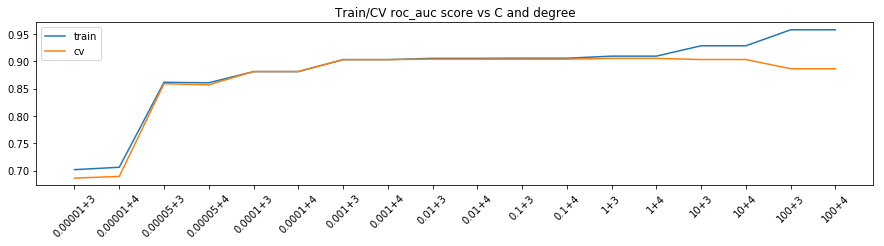

In [155]:
ticks = ['0.00001+3', '0.00001+4', '0.00005+3', '0.00005+4', '0.0001+3', '0.0001+4', '0.001+3', '0.001+4',
         '0.01+3', '0.01+4', '0.1+3', '0.1+4', '1+3', '1+4', '10+3', '10+4', '100+3', '100+4']
plt.figure(figsize=(15,3))
plt.plot(range(len(C)*len(penalties)), tr_scores)
plt.plot(range(len(C)*len(penalties)), cv_scores)
plt.xticks(range(len(C)*len(penalties)), ticks, rotation = 45)
plt.legend(['train', 'cv'])
plt.title("Train/CV roc_auc score vs C and degree")
plt.show()

In [156]:
model = SVC(C=1, degree=3, kernel='rbf', probability=True)
model.fit(train_avgw2v, y_train)

SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=True, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

##### Test Metrics :

Confusion Matrix : 


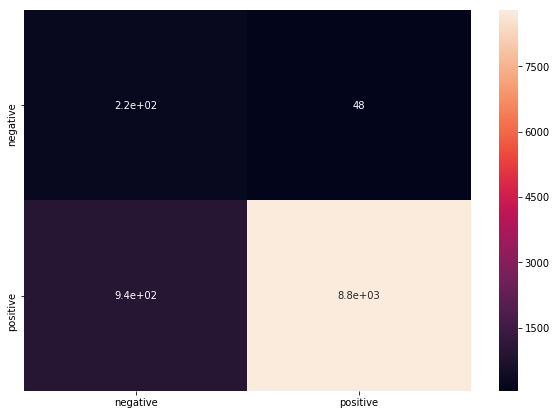

True Positives : 8786
False Positives : 945
True Negatives : 221
False Negatives : 48


In [157]:
y_pred = model.predict(test_avgw2v)
plot_confusion_matrix(np.array(y_test), y_pred)

In [158]:
y_pred = model.predict_proba(test_avgw2v)
roc_auc_score(y_true=y_test, y_score=y_pred[:,1])

0.892975341645467

#### Conclusion for AVGW2V :

1. CV ROC_AUC Score :  0.9050657460900452
2. Train ROC_AUC Score :  0.9091211208502181
3. Test ROC_AUC Score : 0.892975341645467
4. C :  1
5. degree :  3

### TFIDF W2V :

In [159]:
cv_tfidf = train_tfidf[20000:30000]
test_tfidf = train_tfidf[30000:40000]
train_tfidf = train_tfidf[:20000]

print(train_tfidf.shape)
print(test_tfidf.shape)
print(cv_tfidf.shape)

(20000, 50)
(10000, 50)
(10000, 50)


In [160]:
# Hyperparameter tuning :
degree = [3, 4]
C = [0.00001, 0.00005, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100]
cv_scores = []
tr_scores = []
i = 0
for alpha in C:
    for p in degree:
        clf = SVC(C=alpha, kernel='rbf',  degree=p, probability=True, verbose=10)
        clf.fit(train_tfidf, y_train)
        scores = roc_auc_score(y_true=np.array(y_cv), y_score=clf.predict_proba(cv_tfidf)[:,1])
        cv_scores.append(scores)
        scores = roc_auc_score(y_true=np.array(y_train), y_score=clf.predict_proba(train_tfidf)[:,1])
        tr_scores.append(scores)
        print("CV ROC_AUC Score : ", cv_scores[i], " Train ROC_AUC Score : ", tr_scores[i], "C : ", alpha, " degree : ", p)
        i += 1

[LibSVM]CV ROC_AUC Score :  0.674970246774435  Train ROC_AUC Score :  0.6913019120433432 C :  1e-05  degree :  3
[LibSVM]CV ROC_AUC Score :  0.6712869944907273  Train ROC_AUC Score :  0.6869638902315556 C :  1e-05  degree :  4
[LibSVM]CV ROC_AUC Score :  0.7816567751969756  Train ROC_AUC Score :  0.7915700307923956 C :  5e-05  degree :  3
[LibSVM]CV ROC_AUC Score :  0.7936261628716526  Train ROC_AUC Score :  0.8024166787171215 C :  5e-05  degree :  4
[LibSVM]CV ROC_AUC Score :  0.8437123092969308  Train ROC_AUC Score :  0.8488908446579223 C :  0.0001  degree :  3
[LibSVM]CV ROC_AUC Score :  0.8437545023920805  Train ROC_AUC Score :  0.8488370949847298 C :  0.0001  degree :  4
[LibSVM]CV ROC_AUC Score :  0.8771774238041568  Train ROC_AUC Score :  0.883751042867519 C :  0.001  degree :  3
[LibSVM]CV ROC_AUC Score :  0.8771764780062581  Train ROC_AUC Score :  0.8837489011378622 C :  0.001  degree :  4
[LibSVM]CV ROC_AUC Score :  0.8799125662386931  Train ROC_AUC Score :  0.894016636955973

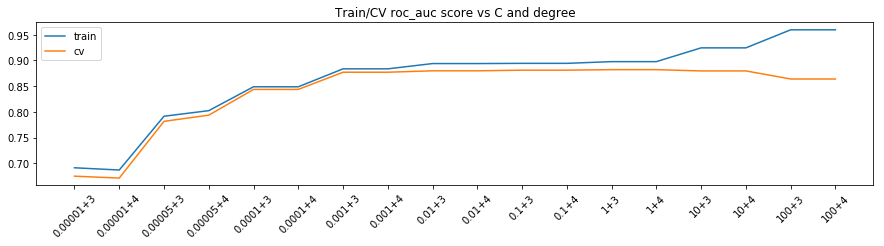

In [161]:
ticks = ['0.00001+3', '0.00001+4', '0.00005+3', '0.00005+4', '0.0001+3', '0.0001+4', '0.001+3', '0.001+4',
         '0.01+3', '0.01+4', '0.1+3', '0.1+4', '1+3', '1+4', '10+3', '10+4', '100+3', '100+4']
plt.figure(figsize=(15,3))
plt.plot(range(len(C)*len(penalties)), tr_scores)
plt.plot(range(len(C)*len(penalties)), cv_scores)
plt.xticks(range(len(C)*len(penalties)), ticks, rotation = 45)
plt.legend(['train', 'cv'])
plt.title("Train/CV roc_auc score vs C and degree")
plt.show()

In [162]:
model = SVC(C=1, degree=3, kernel='rbf', probability=True)
model.fit(train_tfidf, y_train)

SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=True, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

##### Test Metrics :

Confusion Matrix : 


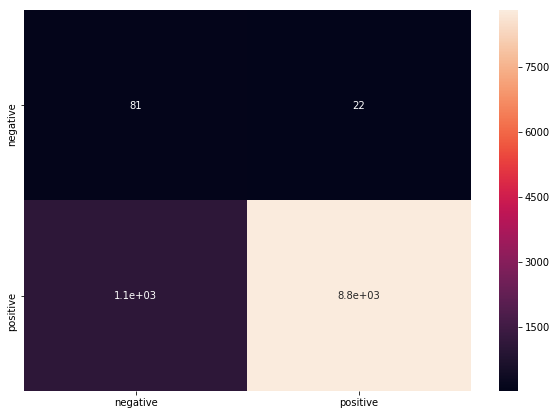

True Positives : 8812
False Positives : 1085
True Negatives : 81
False Negatives : 22


In [163]:
y_pred = model.predict(test_tfidf)
plot_confusion_matrix(np.array(y_test), y_pred)

In [164]:
y_pred = model.predict_proba(test_tfidf)
roc_auc_score(y_true=y_test, y_score=y_pred[:,1])

0.8694115515797183

#### Conclusions for TFIDF W2V:

1. CV ROC_AUC Score :  0.8821843202471685
2. Train ROC_AUC Score :  0.8977807010237262
3. Test ROC_AUC Score :  0.8694115515797183
4. C :  1
5. degree :  3

## Results :

<table><tr><th>Featurization</th><th>Train ROC_AUC</th><th>Test ROC_AUC</th><th>CV ROC_AUC</th><th>Alpha</th><th>Penalty</th></tr><tr><td>BOW Linear SVM</td><td>0.9610021573685849<br></td><td>0.9305193467251538<br></td><td>0.9205223037951129<br></td><td>5e-05<br></td><td>L1</td></tr><tr><td>TFIDF Linear SVM</td><td>0.9719169517002875<br></td><td>0.9508753346424559<br></td><td>0.9484688871784897<br></td><td>1e-05<br></td><td>L1</td></tr><tr><td>AVG-W2V Linear SVM</td><td>0.8902927614259952<br></td><td>0.8955613844658642<br></td><td>0.896676337001294<br></td><td>0.001</td><td>L2</td></tr><tr><td>TFIDF-W2V Linear SVM</td><td>0.8597068919394131<br></td><td>0.8587122347791198</td><td>0.8639065684972638<br></td><td>0.0001</td><td>L1</td></tr><tr><th>Featurization</th><th>Train ROC_AUC</th><th>Test ROC_AUC</th><th>CV ROC_AUC</th><th>C</th><th>Degree of Polynomial</th></tr><tr><td>BOW RBF SVM</td><td>0.9244714789147684</td><td>0.8378130497305225</td><td>0.8553708022388059</td><td>1</td><td>3</td></tr><tr><td>TFIDF RBF SVM</td><td>0.8820058243030617</td><td>0.8395699574200758</td><td>0.8589062500000001</td><td>1</td><td>3</td></tr><tr><td>AVGW2V RBF SVM</td><td>0.9091211208502181</td><td>0.892975341645467</td><td>0.9050657460900452</td><td>1</td><td>3</td></tr><tr><td>TFIDF-W2V RBF SVM</td><td>0.8977807010237262</td><td>0.8694115515797183</td><td>0.8821843202471685</td><td>1</td><td>3</td></tr></table>